In [568]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import seaborn as sns

import random
from collections import deque

plt.style.use('ggplot')

import sys 
sys.path.append('..')


In [569]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2017-01-01']
df_webster = df[df.Cluster == 'WEBSTER']

pred_webster = pd.read_csv('../predictions/best_sweep_tgcn_cpnll_dynamic_2/predictions_TGCN_WEBSTER_trim-shape-30_2.csv', index_col=0)
pred_webster = pred_webster.iloc[:2831]
pred_webster = pred_webster.reset_index(drop=False)

In [570]:

def add_time_columns(df_in, date_name = 'Start Date'):
    df_out = df_in.copy()
    df_out['DayOfWeek'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).dayofweek)
    df_out['Hour'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).hour)
    df_out['Minute'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).minute)
    df_out['HourMinute'] = df_out['Hour'].astype(str) + ':' + df_out['Minute'].astype(str)

    return df_out


df_webster = add_time_columns(df_webster)
pred_webster = add_time_columns(pred_webster, date_name='Date')

In [571]:
## Extract arrival rates from predictions
pred_webster['ArrivalRate'] = pred_webster['WEBSTER_1_pred'].diff(periods=1)
pred_webster = pred_webster.fillna(0)
pred_webster.loc[(pred_webster['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

## Convert service time to hour 
df_webster['Total Duration (hour)'] = df_webster['Total Duration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='WEBSTER_1_pred'>

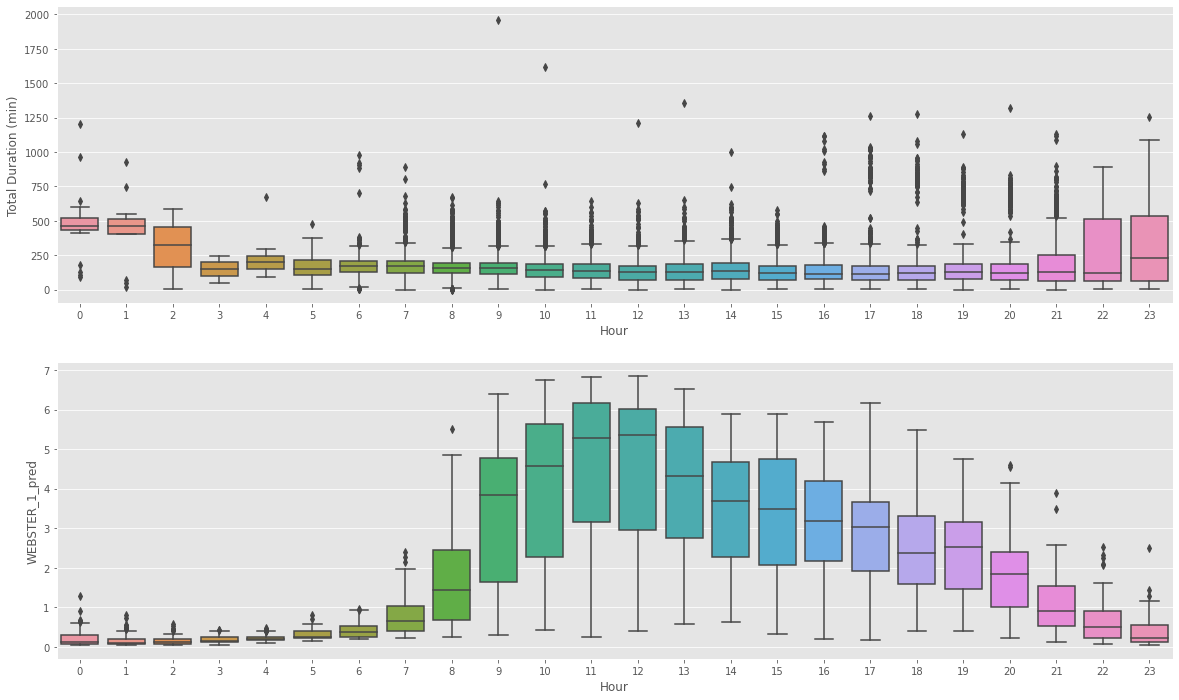

In [572]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=df_webster, x="Hour", y="Total Duration (min)", ax = axes[0])
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[1])

In [573]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

cluster_name = 'WEBSTER'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = pred_webster[(pred_webster['DayOfWeek'] == day_of_week) & (pred_webster['Hour'] == hour)]
    bins = range(0, int(time_specific_df[cluster_name + '_1_pred' ].max()) + 2)
    axs.hist(time_specific_df[cluster_name + '_1_pred'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Predidctions on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.plot_histogram_hour(hour, day_of_week)>

In [574]:
webster_hourly_pluginTime = df_webster.groupby('Hour').mean()
webster_hourly_pluginTime = webster_hourly_pluginTime.reset_index(drop=False)[['Hour', 'Total Duration (min)', 'Total Duration (hour)']]
webster_hourly_pluginTime = webster_hourly_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

webster_hourly_prediction = pred_webster.groupby('Hour').mean()
webster_hourly_prediction = webster_hourly_prediction.reset_index(drop=False)[['Hour', 'WEBSTER_1_pred', 'ArrivalRate']]
webster_hourly_prediction = webster_hourly_prediction.rename(columns={'WEBSTER_1_pred': 'AveragePrediction', 'ArrivalRate': 'AverageArrivalRate'})


In [575]:
webster_halfhourly_prediction = pred_webster.groupby('HourMinute').mean()
webster_halfhourly_prediction = webster_halfhourly_prediction.reset_index(drop=False)[['Hour', 'HourMinute', 'WEBSTER_1_pred', 'ArrivalRate']]

#### Apply to queue

#### Queue estimating length with our predictions and waiting times as mean service time

In [576]:
webster_hourly_pluginTime['AverageDuration (hour)'] = webster_hourly_pluginTime['AverageDuration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='AverageDuration (hour)'>

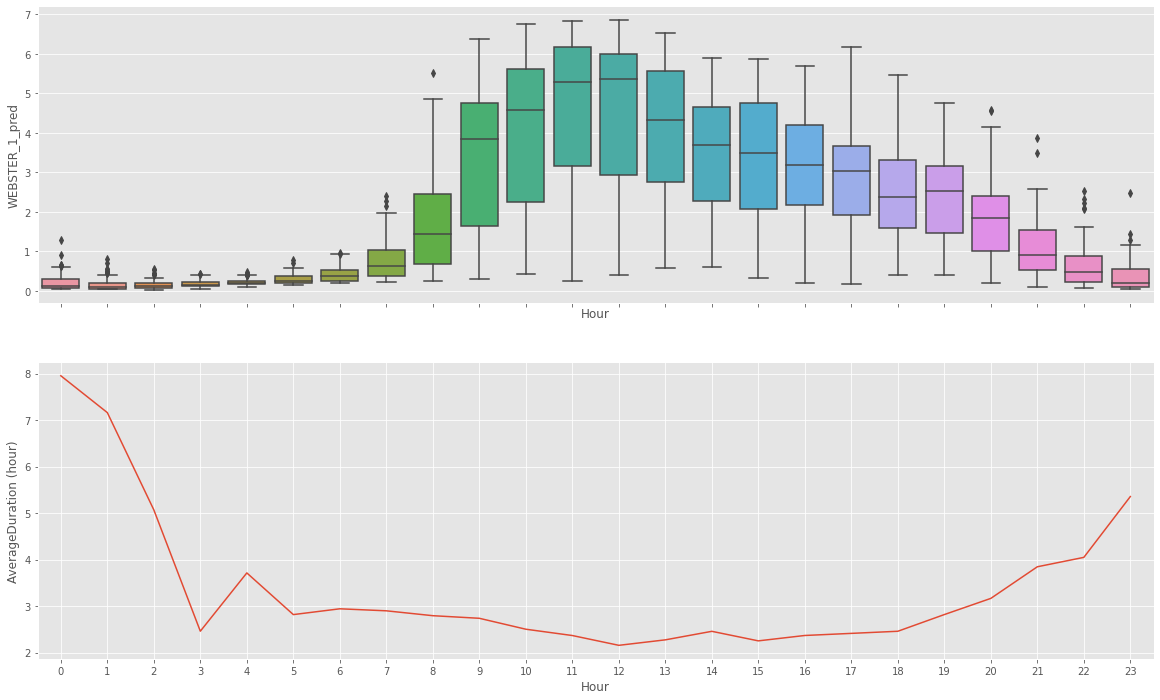

In [577]:
fig, axes = plt.subplots(2, figsize=(20,12), sharex=True)
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[0])
sns.lineplot(data = webster_hourly_pluginTime, x = 'Hour', y = 'AverageDuration (hour)', ax = axes[1])

In [578]:
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

## For hourly aggregated
webster_hourly_prediction['QueueLength'] = np.zeros(len(webster_hourly_prediction))
webster_hourly_prediction.loc[(webster_hourly_prediction['AveragePrediction'] >= 4), 'QueueLength'] = (webster_hourly_prediction['AveragePrediction'] - 4)


In [589]:
webster_hourly_prediction

,Hour,AveragePrediction,AverageArrivalRate,QueueLength
0,0,0.217854,0.007932,0.000000
1,1,0.164575,0.005869,0.000000
2,2,0.159485,0.013451,0.000000
3,3,0.190525,0.021643,0.000000
4,4,0.235059,0.022386,0.000000
5,5,0.293969,0.034091,0.000000
6,6,0.416014,0.068526,0.000000
7,7,0.771317,0.229402,0.000000
8,8,1.714460,0.647947,0.000000
9,9,3.354104,0.774340,0.000000


In [587]:
merged_webster = pred_webster.merge(
    webster_hourly_pluginTime,
    how="left",
    on = 'Hour')

merged_hourly = webster_hourly_prediction.merge(
    webster_hourly_pluginTime,
    how="left",
    on = 'Hour')


#pred_webster['AvgWaitingTime'] * pred_webster['AvgWaitingTime'] 
merged_webster['WaitingTime'] = np.zeros(len(merged_webster))
merged_webster.loc[(merged_webster['QueueLength']!= 0), 'WaitingTime'] = (merged_webster['QueueLength']*merged_webster['AverageDuration (min)'] )

merged_hourly['AverageWaitingTime'] = np.zeros(len(merged_hourly))
merged_hourly.loc[(merged_hourly['QueueLength']!= 0), 'AverageWaitingTime'] = (merged_hourly['QueueLength']*merged_hourly['AverageDuration (min)'] )


<AxesSubplot:xlabel='Hour', ylabel='WaitingTime'>

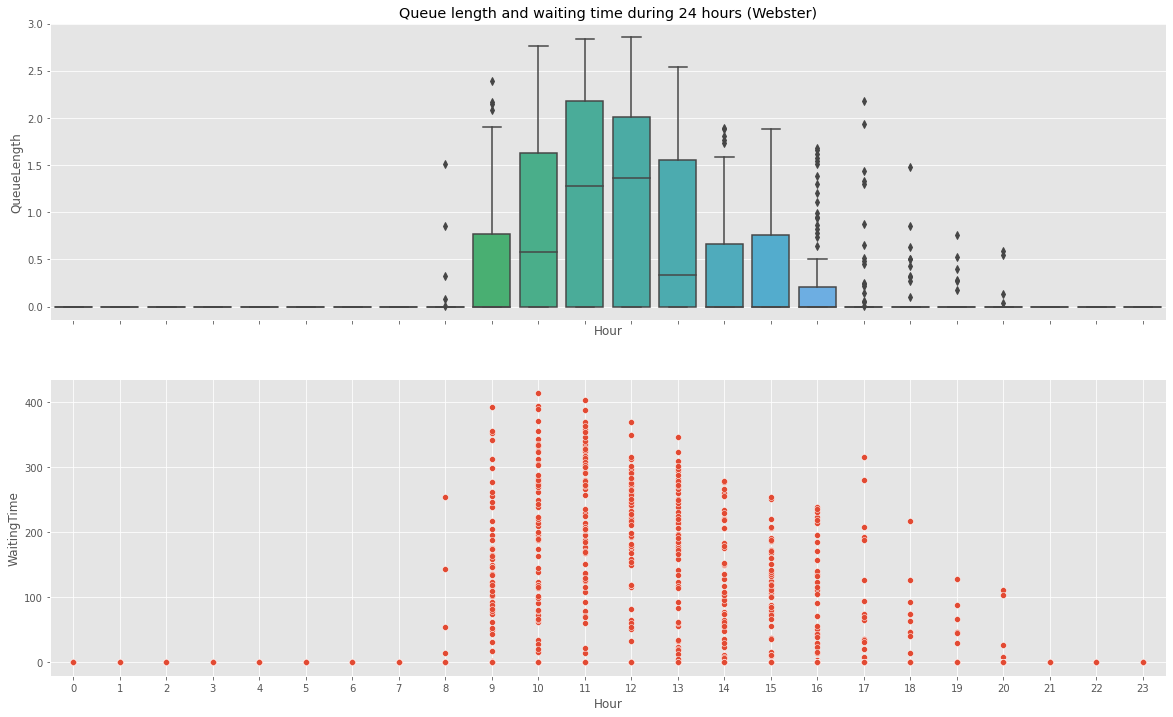

In [608]:
fig, axes = plt.subplots(2, figsize=(20,12), sharex=True)
axes[0].set_title('Queue length and waiting time during 24 hours (Webster)')
sns.boxplot(data=merged_webster, x="Hour", y="QueueLength", ax = axes[0])
sns.scatterplot(data=merged_webster, x = 'Hour', y = 'WaitingTime', ax = axes[1])
#sns.scatterplot(data=merged_hourly, x = 'Hour', y = 'AverageWaitingTime', ax = axes[1], color = 'blue')
#axes[1].legend(loc='upper left', labels=['', 'Nah Bruh'])

##### Below is an attempt to use queuing theory (poisson arrival, exponential service times)

In [581]:
def mmc_queue_hour(lambd, mu, c, time_horizon, seed=None):
    random.seed(seed)  # Set seed for reproducibility

    ## use predictions and observed service times to sample from

    ## sample arrival times

    # interarrival_times = np.random.poisson(lambd, num_customers)
    arrivals = np.random.poisson(lambd, time_horizon)

    ## sample service times
    service_times = np.random.exponential(1/mu, time_horizon)

    #print(service_times)
    #arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        for k in range(len(queue)):
            if (queue[k] < i):
                queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

        

In [640]:
np.random.choice(merged_webster[merged_webster['Hour'] == 0]['ArrivalRate'])

0.0

In [641]:
merged_webster

,Date,WEBSTER_1,WEBSTER_1_pred,WEBSTER_1_true,DayOfWeek,Hour,Minute,HourMinute,ArrivalRate,QueueLength,AverageDuration (min),Average Duration (hour),AverageDuration (hour),WaitingTime
0,2019-05-09 00:30:00,0.0,0.107653,0.0,3,0,30,0:30,0.000000,0.0,477.142949,7.952382,7.952382,0.0
1,2019-05-09 01:00:00,0.0,0.089106,0.0,3,1,0,1:0,0.000000,0.0,429.638462,7.160641,7.160641,0.0
2,2019-05-09 01:30:00,0.0,0.085968,0.0,3,1,30,1:30,0.000000,0.0,429.638462,7.160641,7.160641,0.0
3,2019-05-09 02:00:00,0.0,0.090580,0.0,3,2,0,2:0,0.004611,0.0,304.188889,5.069815,5.069815,0.0
4,2019-05-09 02:30:00,0.0,0.099281,0.0,3,2,30,2:30,0.008702,0.0,304.188889,5.069815,5.069815,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2019-06-29 21:30:00,3.0,0.933279,3.0,5,21,30,21:30,0.000000,0.0,230.797989,3.846633,3.846633,0.0
2491,2019-06-29 22:00:00,3.0,1.057257,3.0,5,22,0,22:0,0.123978,0.0,242.924359,4.048739,4.048739,0.0
2492,2019-06-29 22:30:00,2.0,1.237888,2.0,5,22,30,22:30,0.180631,0.0,242.924359,4.048739,4.048739,0.0
2493,2019-06-29 23:00:00,2.0,0.929511,2.0,5,23,0,23:0,0.000000,0.0,321.356897,5.355948,5.355948,0.0


In [647]:
def mmc_queue_day(df_sessions, c, time_horizon, seed=None, hour = False):
    random.seed(seed)  # Set seed for reproducibility

    ## choose arrival and service rates
    arrivals = []
    service_times = []
    for i in merged_webster['Hour'].unique():
        lambd = np.random.choice(df_sessions[df_sessions['Hour'] == i]['ArrivalRate'])
        mu = np.random.choice(1/df_sessions[df_sessions['Hour'] == i]['AverageDuration (min)'])

        if (hour == True):
            arrivals.append(np.random.poisson(lambd, 1))
            service_times.append(np.random.exponential(1/mu, 1))
            
        elif(hour == False ):
            arrivals.append(np.random.poisson(lambd, 60))
            service_times.append(np.random.exponential(1/mu, 60))



    arrivals = [item for sublist in arrivals for item in sublist]
    service_times = [item for sublist in service_times for item in sublist]
    
    print(arrivals)
    print(service_times)

    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        for k in range(len(queue)):
            if (queue[k] < i):
                queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
[410.3451404159305, 290.49206843249874, 378.236996245773, 180.52960475944917, 99.92745873546764, 25.64353741342257, 22.75119935798406, 195.3389107441282, 13.76655474279455, 340.86393026578196, 146.72928299335945, 201.46240717063955, 108.31549186648438, 347.6217609804938, 131.4467969918949, 187.08096529943217, 331.59298733954057, 150.8474093900674, 278.4733218838706, 54.261078300754754, 46.61689103783642, 106.83429989829301, 205.37563568666283, 131.53410683473712]
Rejected  1 customers during a simulated day (60*24 minutes)


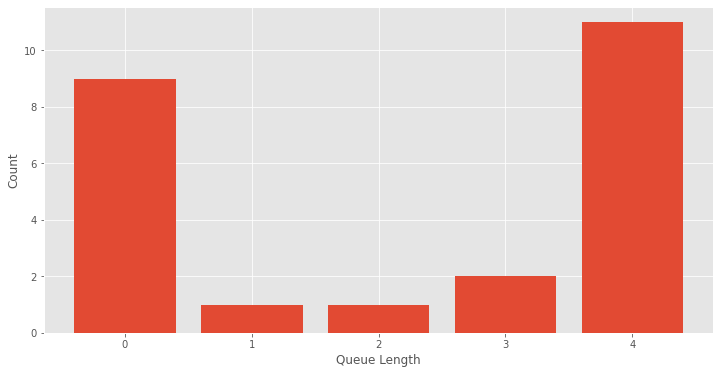

In [659]:
# Example usage
#hour_index = 20
#lambd =  webster_hourly_prediction.iloc[hour_index]['ArrivalRate']  # arrival time np.random.choice(webster_hourly_pluginTime, 1)[0]
#mu =  1 / (webster_hourly_pluginTime.iloc[hour_index]['Total Duration (min)']) # service time  np.random.choice(webster_hourly_pluginTime, 1)[0]  

c = 4  # Number of servers
sim_time = 24 # Number of minutes to simulate

completed_customers, queue_length, rejects = mmc_queue_day(merged_webster, c, sim_time, hour=True)


# print('Rejected % i customers due to insuffient plugs from %ih and %i minutes ahead' % (rejects, hour_index, sim_time) )
print('Rejected % i customers during a simulated day (60*24 minutes)' % (rejects) )


bins = np.arange(min(queue_length), max(queue_length) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(queue_length, bins = bins, align='mid', rwidth=0.8)
ax.set_xlabel('Queue Length')
ax.set_ylabel('Count')
ax.set_xticks(range(int(min(queue_length)), int(max(queue_length) + 1)))
plt.show()

In [626]:
completed_customers

[(138, 241.26232540352615),
 (153, 624.8956349435225),
 (176, 220.51650815562377),
 (305, 457.00813295663136),
 (332, 496.3267690115516),
 (431, 489.978139944778),
 (432, 489.978139944778),
 (435, 489.978139944778),
 (450, 489.978139944778),
 (462, 470.70437971299816),
 (493, 681.2990973674403),
 (556, 879.2794150160454),
 (661, 763.7876225563779),
 (662, 1278.8111092748768),
 (663, 1278.8111092748768),
 (664, 1278.8111092748768),
 (665, 1278.8111092748768),
 (666, 1278.8111092748768),
 (667, 1278.8111092748768),
 (668, 1278.8111092748768),
 (669, 1278.8111092748768),
 (670, 1278.8111092748768),
 (671, 1278.8111092748768),
 (672, 1278.8111092748768),
 (673, 1278.8111092748768),
 (675, 1278.8111092748768),
 (677, 1278.8111092748768),
 (678, 1278.8111092748768),
 (679, 1278.8111092748768),
 (681, 1278.8111092748768),
 (682, 742.9723568740311),
 (683, 742.9723568740311),
 (684, 742.9723568740311),
 (685, 742.9723568740311),
 (686, 742.9723568740311),
 (687, 742.9723568740311),
 (688, 742.

In [602]:
merged_webster

,Date,WEBSTER_1,WEBSTER_1_pred,WEBSTER_1_true,DayOfWeek,Hour,Minute,HourMinute,ArrivalRate,QueueLength,AverageDuration (min),Average Duration (hour),AverageDuration (hour),WaitingTime
0,2019-05-09 00:30:00,0.0,0.107653,0.0,3,0,30,0:30,0.000000,0.0,477.142949,7.952382,7.952382,0.0
1,2019-05-09 01:00:00,0.0,0.089106,0.0,3,1,0,1:0,0.000000,0.0,429.638462,7.160641,7.160641,0.0
2,2019-05-09 01:30:00,0.0,0.085968,0.0,3,1,30,1:30,0.000000,0.0,429.638462,7.160641,7.160641,0.0
3,2019-05-09 02:00:00,0.0,0.090580,0.0,3,2,0,2:0,0.004611,0.0,304.188889,5.069815,5.069815,0.0
4,2019-05-09 02:30:00,0.0,0.099281,0.0,3,2,30,2:30,0.008702,0.0,304.188889,5.069815,5.069815,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2019-06-29 21:30:00,3.0,0.933279,3.0,5,21,30,21:30,0.000000,0.0,230.797989,3.846633,3.846633,0.0
2491,2019-06-29 22:00:00,3.0,1.057257,3.0,5,22,0,22:0,0.123978,0.0,242.924359,4.048739,4.048739,0.0
2492,2019-06-29 22:30:00,2.0,1.237888,2.0,5,22,30,22:30,0.180631,0.0,242.924359,4.048739,4.048739,0.0
2493,2019-06-29 23:00:00,2.0,0.929511,2.0,5,23,0,23:0,0.000000,0.0,321.356897,5.355948,5.355948,0.0


In [601]:
webster_hourly_prediction

,Hour,AveragePrediction,AverageArrivalRate,QueueLength
0,0,0.217854,0.007932,0.000000
1,1,0.164575,0.005869,0.000000
2,2,0.159485,0.013451,0.000000
3,3,0.190525,0.021643,0.000000
4,4,0.235059,0.022386,0.000000
5,5,0.293969,0.034091,0.000000
6,6,0.416014,0.068526,0.000000
7,7,0.771317,0.229402,0.000000
8,8,1.714460,0.647947,0.000000
9,9,3.354104,0.774340,0.000000


In [600]:
webster_hourly_prediction

,Hour,AveragePrediction,AverageArrivalRate,QueueLength
0,0,0.217854,0.007932,0.000000
1,1,0.164575,0.005869,0.000000
2,2,0.159485,0.013451,0.000000
3,3,0.190525,0.021643,0.000000
4,4,0.235059,0.022386,0.000000
5,5,0.293969,0.034091,0.000000
6,6,0.416014,0.068526,0.000000
7,7,0.771317,0.229402,0.000000
8,8,1.714460,0.647947,0.000000
9,9,3.354104,0.774340,0.000000


#### KEEP THE BELOW. AGGREGATION OF LOSSES FROM WANDB

In [ ]:
#mae gru
print(1.067 + 0.9189 + 0.9061 + 0.8333 + 0.6698 + 1.44 + 0.9113 + 1.042)

#cpnll gru 
print(1.011 + 1.196 + 1.33 + 0.5986 + 0.9722 + 2.119 + 0.8776 + 1.294)

#pnll gru
print(-0.05339 - 0.3622 + 0.2183 + 0.5976 + 0.8907 -0.03466 +  0.8994 - 0.6958)

#mse gru
print(2.146 + 1.711 + 1.688 + 1.315 + 0.7061 + 4.376 + 1.527 + 2.202)

7.788399999999998
9.3984
1.4599500000000003
15.6711


In [ ]:
#mae gru
print(np.round(1.091 + 1.052 + 0.9911 + 0.87 + 0.7589 + 1.302 + 0.723 + 1.133,3))

#cpnll gru 
print(np.round(1.073+ 1.354 + 1.449 + 0.6494 + 0.9858 + 1.837 + 0.8555 + 1.392,3))

#pnll gru
print(np.round(-0.003095 - 0.2066+ 0.3424 + 0.6432 + 0.9283 -0.3154+  0.8022 - 0.5931,3))

#mse gru
print(np.round(2.252 + 2.105 + 2.03 + 1.291 + 0.8025 + 3.441 + 0.8477 + 2.542,3))

7.921
9.596
1.598
15.311
